<a href="https://colab.research.google.com/github/SergioManuelJob/ImageModel/blob/master/ModeloDeImagen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de Segmentación Semántica

Modelo extraído de: https://huggingface.co/mattmdjaga/segformer_b2_clothes

In [ ]:
!pip install matplotlib==3.7.1
!pip install torch==2.1.1
!pip install transformers==4.36.2
!pip install Pillow==9.4.0
!pip install gradio==4.14.0

In [11]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation

processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


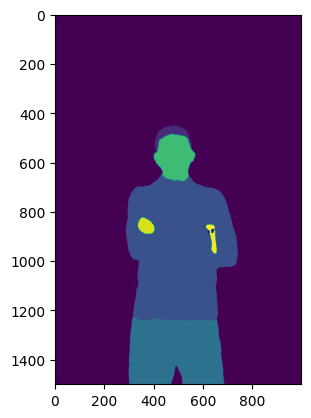

In [5]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch.nn as nn

url = "https://plus.unsplash.com/premium_photo-1673210886161-bfcc40f54d1f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8cGVyc29uJTIwc3RhbmRpbmd8ZW58MHx8MHx8&w=1000&q=80"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(images=image, return_tensors="pt")
output = model(**inputs)
logits = output.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]
plt.imshow(pred_seg)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import gradio as gr

from PIL import Image
from torch import nn

def segment_image(image):
  image = Image.fromarray(image)

  inputs = processor(images=image, return_tensors="pt")
  outputs = model(**inputs)
  logits = outputs.logits.cpu()
  upsampled_logits = nn.functional.interpolate(
          logits,
          size=image.size[::-1],
          mode="bilinear",
          align_corners=False,
      )
  pred_seg = upsampled_logits.argmax(dim=1)[0].numpy()

  colormap = plt.get_cmap('tab20').colors
  colormap = np.array(colormap) * 255


  colored_seg = np.zeros((*pred_seg.shape, 3), dtype=np.uint8)
  for label in range(18):
      colored_seg[pred_seg == label] = colormap[label]
  return colored_seg


gr_image_input = gr.Image(image_mode='RGB', type='numpy')
gr_image_output = gr.Image(type='numpy', label='Segmented Image')

demo = gr.Interface(fn=segment_image, inputs=gr_image_input, outputs=gr_image_output)

In [ ]:
demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://0f337370c2d44c2b36.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
